# Testing masked arrays with donuts

To add masking to Donuts arrays we want to explore making all arrays masked arrays and then supplying a mask or not, depending on the given imager. 

To implement this change we need to do the following:

   1. Pull out the main array operations of Donuts
   1. Add an option to supplying a boolean (True/False or 1/0) array of the same shape as the raw image (including any pre/overscan)
   1. Immediately after loading an image, apply the mask (or not)
   1. Test run all donuts operations for support of masked arrays
   
A very simple test could be to manually load an image, mask it, then run the methods of the ```donuts.image.Image``` class without any changes to see what happens. 

### Update:

It seems like all the functionality of numpy just works with masked arrays, see below. 

The changes required to Donuts are:
   1. Add an option to take in a mask (must be same shape as raw image array)
   1. Make all arrays masked arrays after loading the data.
   1. Apply the mask or supply a null mask if no masking is needed
   1. Proceed as normal

In [1]:
import os
import glob as g
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from donuts import Donuts
from donuts.image import Image

In [2]:
os.chdir('/Users/jmcc/Dropbox/data/ngts/action293930_observeField')
imgs = sorted(g.glob("*.fits"))

[[4480 4474 4460 4498 4471 4423 4440 4464 4391 4481]
 [4356 4531 4424 4429 4464 4477 4526 4471 4500 4493]
 [4505 4436 4448 4425 4357 4424 4494 4512 4285 4488]
 [4434 4434 4414 4533 4500 4476 4417 4225 4431 4480]
 [4478 4482 4472 4500 4372 4455 4471 4252 4422 4509]
 [4435 4586 4426 4521 4393 4484 4450 4560 4450 4455]
 [4474 4435 4460 4534 4355 4410 4440 4350 4440 4486]
 [4478 4473 4461 4371 4449 4404 4424 4340 4483 4458]
 [4539 4440 4408 4552 4547 4413 4463 4615 4466 4446]
 [4422 4471 4521 4492 4521 4378 4363 4369 4516 4469]]
[[64480 64474 64460 64498 64471 64423 64440 64464 64391 64481]
 [64356 64531 64424 64429 64464 64477 64526 64471 64500 64493]
 [64505 64436 64448 64425 64357 64424 64494 64512 64285 64488]
 [64434 64434 64414 64533 64500 64476 64417 64225 64431 64480]
 [64478 64482 64472 64500 64372 64455 64471 64252 64422 64509]
 [64435 64586 64426 64521 64393 64484 64450 64560 64450 64455]
 [64474 64435 64460 64534 64355 64410 64440 64350 64440 64486]
 [64478 64473 64461 64371 64

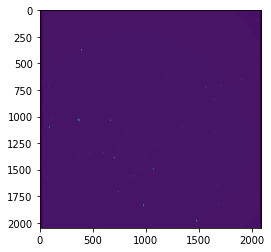

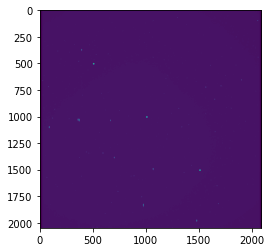

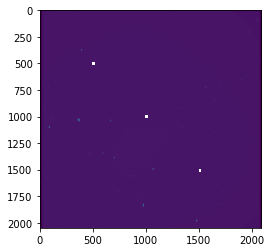

In [3]:
# work on reference image
ref_img = imgs[0]

with fits.open(ref_img) as ff:
    data = ff[0].data
    header = ff[0].header

# make a copy of the original data
data_orig = np.copy(data)

# make a copy to play with for masking
data_copy = np.copy(data)

# add a massive spikes to some pixels
data_copy[500:510, 500:510] += 60000
data_copy[1500:1510, 1500:1510] += 60000
data_copy[1000:1010, 1000:1010] += 60000


# make a mask to exclude 500:510, 500:510
data_copy_mask = np.zeros((data.shape))
data_copy_mask[500:510, 500:510] = 1
data_copy_mask[1500:1510, 1500:1510] = 1
data_copy_mask[1000:1010, 1000:1010] = 1
data_copy_ma = np.ma.array(data_copy, mask=data_copy_mask, fill_value=0)

print(data_orig[500:510, 500:510])
print(data_copy[500:510, 500:510])
print(data_copy_ma[500:510, 500:510])

# display the three images 
plt.imshow(data_orig)
plt.show()
plt.imshow(data_copy)
plt.show()
plt.imshow(data_copy_ma)
plt.show()

Warning, removing y=30 pixels from image upper edge
Warning, removing x=30 pixels from image right edge
Warning, removing y=30 pixels from image upper edge
Warning, removing x=30 pixels from image right edge
Warning, removing y=30 pixels from image upper edge
Warning, removing x=30 pixels from image right edge


/Users/jmcc/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


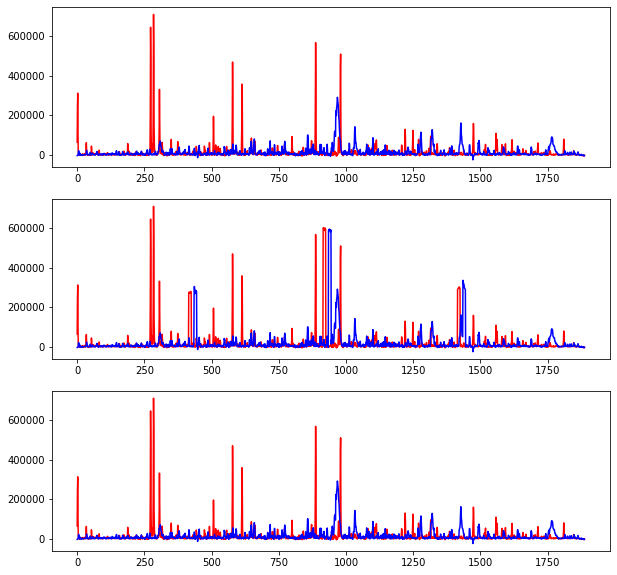

In [4]:
# instanciate the donuts.image.Image class with the original unmasked data
ref_image_orig = Image(data_orig, header)
clyo, cuyo, clxo, cuxo = ref_image_orig.calculate_image_geometry(20, 20, 'x', 65, 32)
ref_image_orig.trim(clyo, cuyo, clxo, cuxo)
ref_image_orig.remove_background(32)
ref_image_orig.downweight_edges()
ref_image_orig.compute_projections()

# instanciate the donuts.image.Image class with the modified data
ref_image_copy = Image(data_copy, header)
clyc, cuyc, clxc, cuxc = ref_image_copy.calculate_image_geometry(20, 20, 'x', 65, 32)
ref_image_copy.trim(clyc, cuyc, clxc, cuxc)
ref_image_copy.remove_background(32)
ref_image_copy.downweight_edges()
ref_image_copy.compute_projections()

# instanciate the donuts.image.Image class with the masked modified data (explosions?)
ref_image_masked = Image(data_copy_ma, header)
clyc, cuyc, clxc, cuxc = ref_image_masked.calculate_image_geometry(20, 20, 'x', 65, 32)
ref_image_masked.trim(clyc, cuyc, clxc, cuxc)
ref_image_masked.remove_background(32)
ref_image_masked.downweight_edges()
ref_image_masked.compute_projections()

# plot the projections
# note the masked section if offset from 505, 505 as it's been added to the original data before prescan correction
fig, ax = plt.subplots(3, figsize=(10, 10))
ax[0].plot(ref_image_orig.proj_x, 'r-', ref_image_orig.proj_y, 'b-')
ax[1].plot(ref_image_copy.proj_x, 'r-', ref_image_copy.proj_y, 'b-')
ax[2].plot(ref_image_masked.proj_x, 'r-', ref_image_masked.proj_y, 'b-')
plt.show()

### Now loop over some images and do some calculations with and without masking

In [5]:
for img in imgs[1:]:
    # load the check image data
    with fits.open(img) as ff:
        cdata = ff[0].data
        cheader = ff[0].header
    
    # make the check image object for unmasked data
    # NOTE: we just use the same image geometry from above
    check_image_orig = Image(cdata, cheader)
    check_image_orig.trim(clyo, cuyo, clxo, cuxo)
    check_image_orig.remove_background(32)
    check_image_orig.downweight_edges()
    check_image_orig.compute_projections()
    
    # make the check image object for masked data
    # NOTE: reuse the same mask as above
    cdata_copy = np.copy(cdata)
    cdata_copy_ma = np.ma.array(cdata_copy, mask=data_copy_mask)
    check_image_masked = Image(cdata_copy_ma, cheader)
    check_image_masked.trim(clyo, cuyo, clxo, cuxo)
    check_image_masked.remove_background(32)
    check_image_masked.downweight_edges()
    check_image_masked.compute_projections()
    
    # compute the offset for original data
    check_image_orig.compute_offset(ref_image_orig)
    print(f"{check_image_orig.x} {check_image_orig.y}")
    
    # compute the offset for the unmasked bad data
    check_image_orig.compute_offset(ref_image_copy)
    print(f"{check_image_orig.x} {check_image_orig.y}")
    
    # compute the offset for masked data
    check_image_masked.compute_offset(ref_image_masked)
    print(f"{check_image_masked.x} {check_image_masked.y}")
    
    print('\n\n')

/Users/jmcc/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


-2.2599040512989017 pix -5.8162975798505325 pix
-2.257796996015776 pix -5.781679387991998 pix
-2.259908327957999 pix -5.8161524357495225 pix



-2.700188818941793 pix -5.932874065790522 pix
-2.6973465213729084 pix -5.87796958626776 pix
-2.700192918687918 pix -5.932688773335075 pix



-2.8972967263997864 pix -5.952946652488053 pix
-2.895123267857612 pix -5.898357264498125 pix
-2.8973000343739446 pix -5.952752930168653 pix



-2.809640776319932 pix -5.777518596277773 pix
-2.8075248768199588 pix -5.736309969311035 pix
-2.8096448928241866 pix -5.777401086604833 pix



-2.8704946398258735 pix -5.69999512030885 pix
-2.867985778034119 pix -5.653486234225819 pix
-2.8704981999317796 pix -5.699875819712335 pix



-2.8208873963882555 pix -5.646666478781254 pix
-2.8183352107000155 pix -5.598422763771885 pix
-2.8208906312537705 pix -5.646444569070626 pix



-2.751948819554319 pix -5.485811720664331 pix
-2.749354080417437 pix -5.413494505331886 pix
-2.7519529975878614 pix -5.485668469229273 pix



-

In [6]:
data_copy_ma[500:510, 500:510]

masked_array(
  data=[[--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --]],
  mask=[[ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  Tr